<a href="https://colab.research.google.com/github/linwoodc3/Blogs/blob/master/space_launch_wars_who_dominates_the_launch_pad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Launch Wars: Data Reveals Winner
### Using data to find out who dominates the launch pad and space!

How are private spaceflight companies like SpaceX changing the business of transporting people and cargo to space? We will explore this question using a special Python tool called BeautifulSoup to "collect" information from a [website that tracks spacecraft launches](https://spaceflightnow.com/) with [public-facing launch logs](https://spaceflightnow.com/launch-log/). But let's start with the main points of our findings:

* SpaceX's dominates the space launch market, with its Falcon 9 handling 70% of all worldwide space launches. The same cannot be said for traditional players, like Soyuz, who are either stagnant or see a decline. All this despite is happening growth in the space launch market overall.

* We make the visual in this notebook to make this crystal clear!

### Who is this for?

This project is perfect for financial analysts, beginning coders, and experienced coders. Financial analysts will appreciate the data-driven conclusions. Beginning coders will learn how to use [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) to grab data from the web, while experienced programmers can brush up on their skills for collecting and organizing information.

By the end, you'll have a Economist-style chart showing you how SpaceX came out of nowhere to crush the space launch market.

>Note: It took several hours to do the analysis and data crunching. Writing the key findings took all of 20 minutes. This is the life of using data to drive decisions!

In [1]:
###################
# Standard library
###################

import re
import os
import datetime


##################
# Third-party library
##################

import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from dateutil.parser import parse
from IPython.display import clear_output
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import rcParams, rcParamsDefault


# Pull data from SpaceFlightNow website (Step 1)

We start by "collecting" the data from the SpaceflightNow website. Launch logs are split over several pages so we make a list of the urls.

In [2]:
sites = [
    "http://spaceflightnow.com/launch-log-2004-2008/",
         "http://spaceflightnow.com/launch-log-2009-2011/",
         "http://spaceflightnow.com/launch-log-2012-2014/",
         "http://spaceflightnow.com/launch-log-2015-2016/",
    "http://spaceflightnow.com/launch-log-2017-2018/",
         "http://spaceflightnow.com/launch-log-2019-2020/",
         "http://spaceflightnow.com/launch-log-2021-2022/",
         "https://spaceflightnow.com/launch-log/"
]

Now we make a `for loop` to pull the HTML content for each page, and then we rip out the info we care about.

In [3]:
stored_results=[] # hold results so you do not hit spaceflightnow.com all the time

In [4]:
dfs=[]
ready = 'no'
turned = 'no'
current_year = '2024'

for s in sites:
    r = requests.get(s)
    stored_results.append([s,r])
    soup=BeautifulSoup(r.content,'html.parser')
    p={}
    for g in ["launchdate","mission","missiondata","missdescrip"]:
        p[g]=soup.find_all(class_=g)
    df = pd.DataFrame()


    for w,x,y,z in zip(p['launchdate'],p['mission'],p['missiondata'],p['missdescrip']):
        launch_date = w.getText().strip()
        dad = launch_date
        mission= x.getText()
        miss_data=y.getText()
        miss_descrip=z.getText()
        if s == "https://spaceflightnow.com/launch-log/":
            current_year = '2024'
            if 'January' in dad and ('2023' not in dad or '2024' not in dad) and turned == 'no':
                turned = 'yes'
                current_year = '2024'
                switched='yes'
            if (turned == 'yes' and (('January' not in dad and ('2023' not in dad or '2024' not in dad))) or ('January' not in dad and current_year=='2023')):
                current_year = '2023'
                switched='yes'
            if '2023' in dad or '2024' in dad:
                current_year = ''
                switched='no'

            else:
                launch_date = launch_date

            launch_date=launch_date.strip()+" "+current_year
        else:
            current_year = ''


        row = pd.DataFrame(pd.Series({
            'launch_date':launch_date,
            'mission':mission,
            'mission_data':miss_data,
            'mission_description':miss_descrip
                                     })).T
        df = pd.concat([df,row]).reset_index(drop=True)
    dfs.append(df)

# Combined launch data and clean it for analysis (Step 2)

We have our data and need to clean it. First, let's take a look at what we have.

In [5]:
starting = pd.concat(dfs).reset_index(drop=True)
starting.loc[lambda x: x['mission']=='Electron • \‘The Moon God Awakens\’','launch_date']='Dec. 15, 2023'
starting.tail()

,launch_date,mission,mission_data,mission_description
1697,"Jan. 15, 2023",Falcon Heavy • USSF 67,Launch time: \n\n2256 GMT (5:56 p.m. EST)\n\nL...,\nA SpaceX Falcon Heavy rocket launched the US...
1698,"Jan. 10, 2023",RS-1 • Flight 1,Launch time: \n\n2327 GMT (6:27 p.m. EST)\n\nL...,\nAn ABL RS-1 rocket failed during launch on i...
1699,"Jan. 9/10, 2023",Falcon 9 • OneWeb 16,Launch time: \n\n0450 GMT on 10th (11:50 p.m. ...,\nA SpaceX Falcon 9 rocket launched 40 satelli...
1700,"Jan. 8, 2023",Long March 7A • Shijian 23,Launch time: \n\n2200 GMT (5:00 p.m. EST)\n\nL...,\nA Chinese Long March 7A rocket launched laun...
1701,"Jan. 3, 2023",Falcon 9 • Transporter 6,Launch time: \n\n1456 GMT (9:56 a.m. EST)\n\nL...,\nA SpaceX Falcon 9 rocket launched the Transp...


Next, we will use the functions below to clean our data.

In [6]:
def fix_date(d):
    """Utility function to take launch date class text, split on two dates, and sub
    in the maximum date"""
    da = d.split('/')
    if len(da)>1:
        da2 = da[0].split(' ')[0].strip()
        da3 = da2+" "+da[1].strip()

    else:
        da3=d.strip()
    return da3

def tsub(tt):
    '''utility to remove 2 numbers after a colon'''
    ru = re.sub(r":\d+", "",tt)
    return ru

def ltime(ti):
    """Utility function to take in time string and rip
    out the UTC or GMT"""
    pattern = re.compile('([\d\:]{3,7}) ?[(UTC)|(GMT)]')
    if pattern.search(ti):
        times = pattern.search(ti).groups(1)[0].replace(':',"")
    else:
        times = ti

    return times

def lsite(ti):
    """Utility function to take in a string and rip
    out the launch site"""
    pattern = re.compile("(?<=Launch site: )([\w\d\s\:\- \,\.]+)")#)'{\bLaunch site\: \b\s}(.*)')
    if pattern.search(ti):
        times = pattern.search(ti).groups(1)[0].replace(':',"").strip()
    else:
        times = ti
    return times


Before running the functions, we perform some manual cleaning to address errors encountered while building the functions.

In [7]:
starting.loc[lambda x: x['launch_date']=='Nov. 30/Dec. 1, 2008','launch_date']='Dec. 1, 2008'
starting.loc[lambda x: x['launch_date']=='Feb. 28/March 1, 2005','launch_date']='Mar. 1, 2005'
starting.loc[lambda x: x['launch_date']=='Jan. 31/Feb. 1, 2015','launch_date']='Feb. 1, 2015'
starting.loc[lambda x: x['launch_date']=='H-2A • Optical Data Relay Satellite','launch_date']='Nov. 29, 2020'
starting.loc[lambda x: x['launch_date'].str.contains('NET June'),'launch_date']='June 5, 2024'
starting.loc[lambda x: x['launch_date'].str.contains('May 31/June 1'),'launch_date']='June 1, 2024'
starting.loc[lambda x: x['launch_date'].str.contains('NET February'),'launch_date']='February 15, 2024'
starting.loc[lambda x: x['launch_date'].str.contains('December 31 / January 1'),'launch_date']='January 1, 2024'
starting.loc[lambda x: x['launch_date'].str.contains('NET December'),'launch_date']='December 15, 2023'
starting.loc[lambda x: x['launch_date'].str.contains('Aug. 31/Sept. 1'),'launch_date']='September 1, 2023'
starting.loc[lambda x: x['launch_date'].str.contains('April30/May 1'),'launch_date']='May 1, 2023'
starting.loc[lambda x: x['launch_date'].str.contains("Feb. 17, 202"),'launch_date']='Feb. 17, 2023'
starting.loc[lambda x: x['mission_data'].str.contains("0228:25 GMT"),'mission_data']='Launch time: 0228 GMT on 25th (10:28:25 p.m. EDT on Oct. 24th)\
Launch site: SLC-2W, Vandenberg Air Force Base, Calif.'
starting.loc[lambda x: x['mission_data'].str.contains("1850:57 GMT"),'mission_data']='Launch time: 1850 GMT (2:50:57 p.m. EDT) \
Launch site: SLC-2W, Vandenberg Air Force Base, Calif.'
starting.loc[lambda x: x['mission_data'].str.contains("0746:25 GMT"),'mission_data']='Launch time: 0746 GMT (3:46:25 a.m. EDT) \
Launch site: SLC-2W, Vandenberg Air Force Base, Calif.'
starting.loc[lambda x: x['mission_data'].str.contains("1116:39 GMT"),'mission_data']='Launch time: 1116 GMT (7:16:39 a.m. EDT) \
Launch site: Baikonur Cosmodrome, Kazakhstan'
starting.loc[lambda x: x['mission_data'].str.contains('0017:46'),'mission_data']='Launch time: 0017 GMT on June 1 (8:17:46 p.m. EDT on May 31)\nLaunch site: Tanegashima Space Center, Japan'
starting.loc[lambda x: x['mission_data'].str.contains("03:13:59"),'mission_data']='Launch time: \n\n0313 UTC\n\nLaunch site: China Jiuquan Satellite Launch Center (JSLC LC-90)'
starting.loc[lambda x: x['mission_data'].str.contains('1452:14 UTC'),'mission_data']='Launch time: \n\n10:52:14 a.m. EDT (1452 UTC)\n\nLaunch site: SLC-41, Cape Canaveral Space Force Station, Florida'
starting.loc[lambda x: x['mission'].str.contains("H-2A • QZS 1R"),'launch_date']=datetime.datetime(day=26, month=10, year=2021).strftime('%B %d, %Y')
starting.loc[lambda x: x['mission'].str.contains("Soyuz 2-1v • Razbeg"),'launch_date']=datetime.datetime(day=9, month=9, year=2023).strftime('%B %d, %Y')
starting.loc[lambda x: x['mission'].str.contains("Alpha • DREAM"),'launch_date']=datetime.datetime(day=5, month=9, year=2021).strftime('%B %d, %Y')
starting.loc[lambda x: x['mission'].str.contains("Long March 6 • Ningxia 1"),'launch_date']=datetime.datetime(day=9, month=7, year=2021).strftime('%B %d, %Y')
starting.loc[lambda x: x['mission'].str.contains("Long March 3C • Tianlian 1-05"),'launch_date']=datetime.datetime(day=6, month=7, year=2021).strftime('%B %d, %Y')
starting.loc[lambda x: x['mission'].str.contains("Vega • THEOS-2 & FORMOSAT-7R/TRITON"),'launch_date']=datetime.datetime(day=9, month=10, year=2023).strftime('%B %d, %Y')
starting.loc[lambda x: x['launch_date'].str.contains("Feb. 1, 2018"),'launch_date']=datetime.datetime(day=1, month=2, year=2018).strftime('%B %d, %Y')

Now we run the cleaning functions to return clean, tidy data for analysis.

In [8]:
# run cleaning functions
final_data = pd.concat([starting,starting.mission.str.split('•',expand=True).rename(columns={0:'vehicle_name',1:'mission_name'}).assign(vehicle_name=lambda x: x['vehicle_name'].str.strip(), mission_name=lambda x: x['mission_name'].str.strip())],axis=1).loc[lambda x: x['mission_data'].str.contains('TBD')==False].assign(
    new_date=lambda x: (x.launch_date.apply(fix_date)+" "+x.mission_data.apply(ltime)).apply(parse),
    mission_data=lambda x: x['mission_data'].str.strip().str.replace('\n\n','').str.strip(),
    mission_description=lambda x: x['mission_description'].str.strip().str.replace('\n\n','').str.strip(),
    vehicle_name=lambda x: x['vehicle_name'].str.strip(),
    mission_name=lambda x: x['mission_name'].str.strip(),
    launch_site = lambda x: x['mission_data'].apply(lsite)
).sort_values('new_date',ascending=False)

# add columns for colors and visualization
final_data = final_data.assign(
    colors=np.where(final_data.vehicle_name=='Falcon 9',"#E3120B",np.where(final_data.vehicle_name=='Soyuz','#595959','#D9D9D9')),
    groups=np.where(final_data.vehicle_name=='Falcon 9',"A",np.where(final_data.vehicle_name=='Soyuz','B','C')),
    widths=np.where(final_data.vehicle_name=='Falcon 9',8,np.where(final_data.vehicle_name=='Soyuz',1.2,0.5)),
    zorder = np.where(final_data.vehicle_name=='Falcon 9',100,np.where(final_data.vehicle_name=='Soyuz',-5,-10))

)

Next, we aggregate the data to prepare it for visual analysis. Remember, we want to understand how private companies like **SpaceX*** have impacted the launch service market. Our source provided a row for each launch, containing the space vehicle used, the date, and other relevant data. By identifying which vehicles are SpaceX vehicles versus those of other providers, we can use computational methods to explore our question. We'll aggregate the data here:

In [9]:
plot_data = final_data.set_index('new_date').groupby(['vehicle_name','groups','colors','widths']).resample('YS')['mission_name'].count().reset_index(name='count_of_launches')

# Build Exploratory Visuals (Step 3)

With clean data and a hypothesis, we can begin to investigate our question. We start by creating a palette to visualize vehicles by colors. I searched for SpaceX vehicle names and built a palette to make their most-used rocket stand out.

In [10]:
def palmaker(row):
    rec = {row['vehicle_name']:row['colors']}
    return rec

ce = final_data.drop_duplicates('vehicle_name')[['vehicle_name','colors']].apply(palmaker,axis=1).values
combined_dict = {key: value for d in ce for key, value in d.items()}

palette3 = combined_dict

You often spend hours or days just "getting to know" your data; this exploration will reveal errors, outliers, and missing data. The code below corrects errors that would impact our ability to explore visuals made from this data. Wikipedia's [`2XXX in Spaceflight`](https://en.wikipedia.org/wiki/2023_in_spaceflight) pages are probably a good alternative to fill in data gaps. Here is what I found using SpaceflightNow's logs:


## Troubleshooting Data Journal

| Problem Found | How I Solved It |
|---|---|
| **Missing data**; all 2019 data | I found no 2019 launch data despite several pages on SpaceflightNow claiming to have such data. I tweeted the website to let them know of the problem and request a fix; no response yet. My interim solution was to interpolate the data to fill in the 2019 value; I used the linear parameter in the `pandas.Series.interpolate` method. |
| **Current year launches included; incomplete data**  | Using 2024 launch data gives a false **dip** since we are only halfway through the year. To remove this, I used ARIMA time forecasts to fill in the last date.|
| **Missing data**; part of 2020 probably missing | This **missing data likely impacts the interpolated values used for 2019**. I tried to interpolate 2019 and 2020 to see how that worked/looked.  |

In [11]:
interpolated_dfs = []

final_data2 = pd.DataFrame()
# Create a list of colors
colors2 = ['#E3120B', '#595959', '#D9D9D9']
palette ={'Falcon 9': '#E3120B', 'Soyuz': '#595959', 'All others': '#D9D9D9'}
# Create a custom color palette
palette2 = sns.color_palette(colors2)


urange = pd.DatetimeIndex(pd.date_range('2003-01-01',final_data.new_date.dt.date.max(),freq='YS'))

for uni in final_data.vehicle_name.unique():
    u = final_data.loc[lambda x: x['vehicle_name']==uni]
    u = u.set_index('new_date').groupby(['vehicle_name','groups','colors','widths','zorder']).resample('YS')['mission_name'].count().reset_index(name='count_of_launches')
    if u.new_date.dt.date.min()==u.new_date.dt.date.max():
        a =u.new_date.dt.date.min() - pd.DateOffset(years=1)
    else:
        a =u.new_date.dt.date.min()
    z =u.new_date.dt.date.max()
    urange = pd.DatetimeIndex(pd.date_range(a,z,freq='YS'))
    u2 = u.set_index('new_date').reindex(urange,fill_value=np.nan)
    if pd.Timestamp('2019-01-01 00:00:00') in u2.index:
        u2.loc['2019-01-01','count_of_launches']=np.nan
        u2.loc['2019-01-01','vehicle_name']=uni
    if pd.Timestamp('202--01-01 00:00:00') in u2.index:
        u2.loc['2020-01-01','count_of_launches']=np.nan
        u2.loc['2020-01-01','vehicle_name']=uni

    u2['count_of_launches'] = u2['count_of_launches'].interpolate(method='linear').fillna(0).round(0)
    u2['vehicle_name']=uni
    u2['groups']=u.iloc[0]['groups']
    u2['widths']=u.iloc[0]['widths']
    u2['colors']=u.iloc[0]['colors']
    u2['zorder']=u.iloc[0]['zorder']


    lw = final_data.loc[lambda x: x['vehicle_name']==uni].iloc[0]['widths']
    if pd.Timestamp('2024-01-01 00:00:00') in u2.index and u2.shape[0]>2:
        # Fit ARIMA model (adjust order parameters as needed)
        model = ARIMA(u2['count_of_launches'][:-1], order=(2, 1, 2))
        fit_model = model.fit()
        last_prediction = fit_model.forecast(1)
        u2.loc[lambda x: x.index==last_prediction.index.values[0],'count_of_launches']=last_prediction.round(0).values[0]
    interpolated_dfs.append(u2)
    clear_output()

Let's combine that transformed data:

In [12]:
interpolated_plot_data = pd.concat(interpolated_dfs)


Now we add a column to track the "market share" each vehicle has for a year of launches. For example, if the Falcon 9 launched 10 times and all launch service providers completed 100 launches in a year, Falcon 9's share would be 10%. This next block calculates that for every vehicle for every year.

<ipython-input-13-9dec231220b9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(foc,ax=ax,palette=custom_palette, edgecolor='black', linewidth=1, zorder=10)  # set zorder to ensure highlight is on top)
<ipython-input-13-9dec231220b9>:15: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(foc,ax=ax,palette=custom_palette, edgecolor='black', linewidth=1, zorder=10)  # set zorder to ensure highlight is on top)


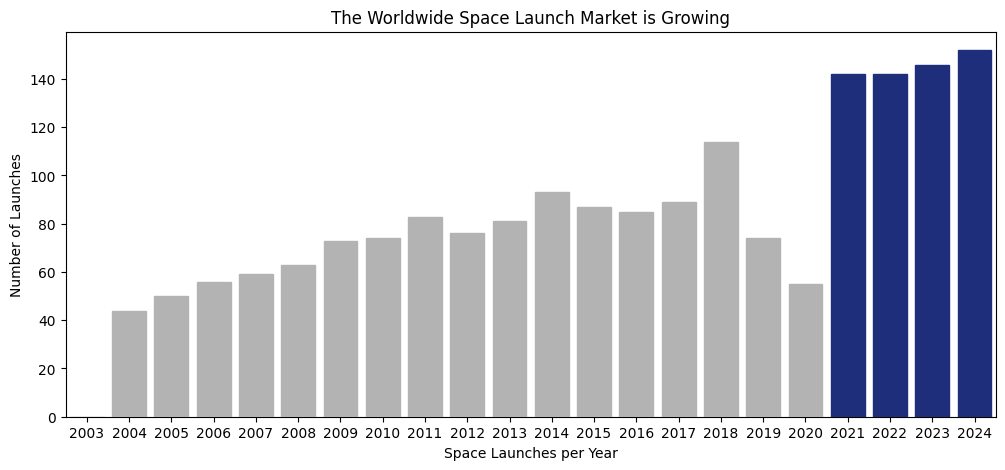

In [13]:
foc=interpolated_plot_data[['count_of_launches']].reset_index(names='new_date').groupby('new_date')['count_of_launches'].sum()

interpolated_plot_data=interpolated_plot_data.assign(launch_prop=lambda x: (x['count_of_launches']/foc.loc[x.index]).fillna(0))
# f,ax=plt.subplots(figsize=(12,9))
# sns.barplot(foc.assign(yrs=foc.index.year).set_index('yrs'),ax=ax)
foc.index=foc.index.year
f,ax=plt.subplots(figsize=(12,5))
# Define custom color palette (replace '#1F2E7A' with your desired color)
custom_palette = ['#B3B3B3', '#1f2e7a']  # light gray, dark blue

# Function to define bar color and outline based on value
def highlight_bar(val):
  return custom_palette[0] if val <= 120 else custom_palette[1]

sns.barplot(foc,ax=ax,palette=custom_palette, edgecolor='black', linewidth=1, zorder=10)  # set zorder to ensure highlight is on top)

# Get bar values and apply custom colors
bars = ax.patches  # Get collection of bars

for bar in bars:
    bar_height = bar.get_height()  # Get the height of the bar
    bar.set_color(highlight_bar(bar_height))  # Set color based on value

# Customize the plot further (optional)
plt.xlabel('Space Launches per Year')
plt.ylabel('Number of Launches')
plt.title('The Worldwide Space Launch Market is Growing')
plt.show()

We found something interesting about the entire market: there are more launches every year, suggesting that there are more patrons for the space launch business! Let's keep this in mind as we look at SpaceX; if they are launching more, they are taking the biggest piece of a growing pie.

### Isolating Data for Ease of Use

Here, we isolate the data for plotting; we put all **Falcon 9** data in one dataframe, one for Russia's Soyuz, and then one for everything else. I focused on the Falcon 9 and Soyuz afer some exploratory visuals, as we'll see below.

In [14]:
falcon = plot_data.loc[lambda x: x['vehicle_name']=='Falcon 9']
soyuz = plot_data.loc[lambda x: x['vehicle_name']=='Soyuz']
everyone_else = plot_data.loc[lambda x: x['vehicle_name'].str.contains('Falcon 9|Soyuz')==False]


falcon_int = interpolated_plot_data.loc[lambda x: x['vehicle_name']=='Falcon 9']
soyuz_int = interpolated_plot_data.loc[lambda x: x['vehicle_name']=='Soyuz']
everyone_else_int = interpolated_plot_data.loc[lambda x: x['vehicle_name'].str.contains('Falcon 9|Soyuz')==False]

And our first visual!

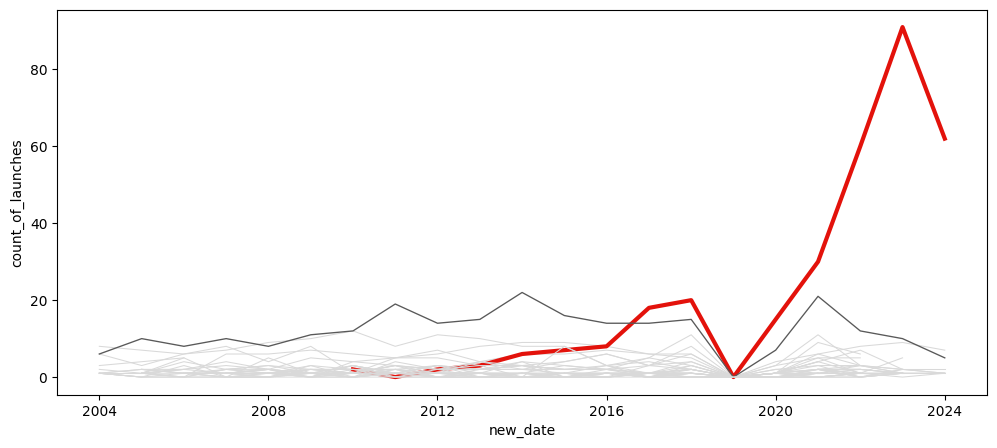

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

f,ax=plt.subplots(figsize=(12,5))
sns.lineplot(
    data=plot_data,#plot_data,
    hue='vehicle_name',palette=palette3,x='new_date',y='count_of_launches',legend=False,size='widths',ax=ax,zorder=100,
)

plt.show()

Red is the Falcon 9 and the darker grey line is the Soyuz. You see how these two rise above the rest and hence, my inclination to isolate those rockets to their own dataframes. I also can see with the non-interploated and forecast transformations, my dips in 2019 and 2024 are severe. Now we plot the transformed data. I also export to an SVG format to make a "prettier" visual in visual design software.

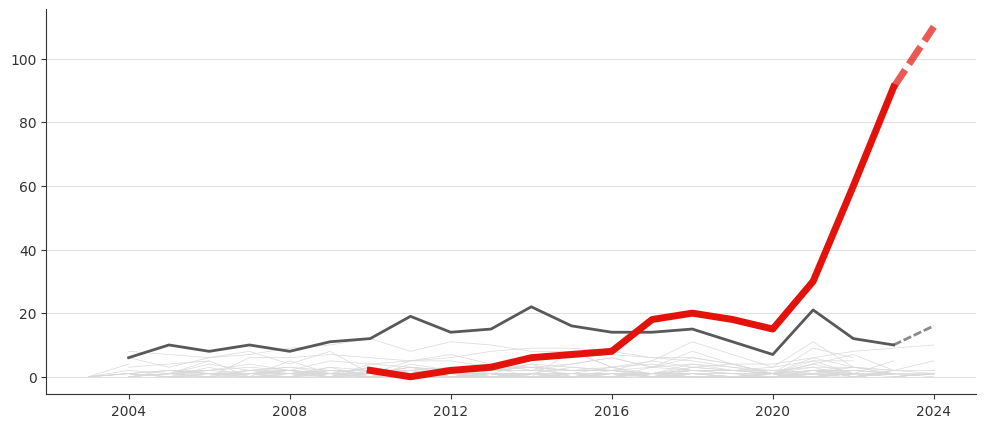

In [24]:
f,ax=plt.subplots(figsize=(12,5))

# Create the plot with custom colors
# all other rockets launches plot
sns.lineplot(data=everyone_else_int[:-1].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name', palette=palette3,legend=False,linewidth =0.5,ax=ax,zorder=-10)
sns.lineplot(data=everyone_else_int[-2:].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name', linestyle=(0, (3, 1)),palette=palette3,legend=False,linewidth =0.5,ax=ax,zorder=-10)

# soyuz rocket launches plot
sns.lineplot(data=soyuz_int[:-1].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name', palette=palette3,legend=False,linewidth =2,ax=ax,zorder=5)
sns.lineplot(data=soyuz_int[-2:].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name',linestyle=(0, (3, 1)), palette=palette3,legend=False,linewidth =2,alpha=0.7,ax=ax,zorder=5)

# falcon 9 rocket launches plot
sns.lineplot(data=falcon_int[:-1].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name', palette=palette3,legend=False,linewidth =5,ax=ax,zorder=10)
sns.lineplot(data=falcon_int[-2:].reset_index(names='new_date'), x='new_date', y='count_of_launches', hue='vehicle_name',linestyle=(0, (3, 1)), palette=palette3,legend=False,linewidth =5,alpha=0.7,ax=ax,zorder=10)

plt.xlabel('')
plt.ylabel('')

# Hide top and right spines (axes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set axis colors and text color
axis_color = '#333333'
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.spines['right'].set_color(axis_color)  # Might be hidden by default

ax.tick_params(colors=axis_color, which='both')  # Set tick colors
ax.xaxis.label.set_color(axis_color)  # Set X-axis label color
# Add light horizontal gridlines
ax.yaxis.grid(True, which='both',linewidth=0.5, color='lightgray')  # Adjust as needed

ax.yaxis.label.set_color(axis_color)  # Set Y-axis label color
# Show the plot
plt.savefig('space_launches2.svg',dpi=300)

# Explanatory Visuals: Who Dominates the Launch Market and How is the Market Changing?

Here, we look at the proportion of "market share", where we say market share is the proportion of launches by one vehicle compared to launches by all vehicles.

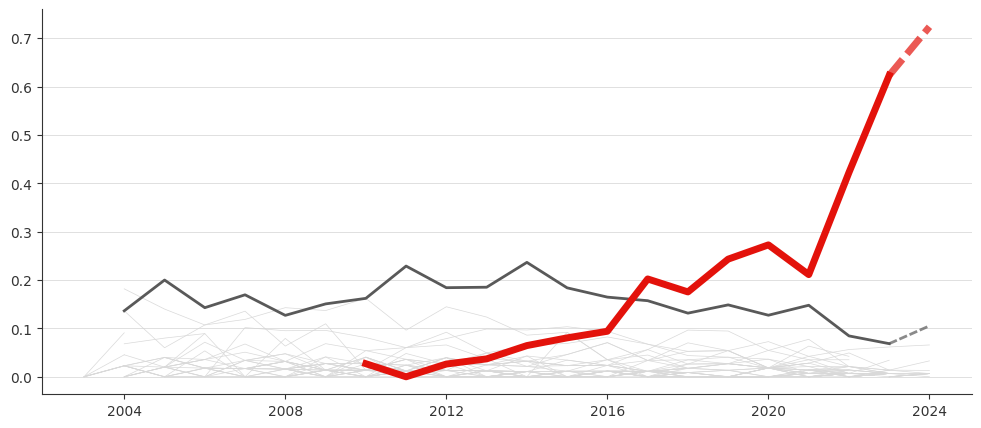

In [23]:


f,ax=plt.subplots(figsize=(12,5))

# Create the plot with custom colors
# all other rockets launches plot
sns.lineplot(data=everyone_else_int[:-1].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name', palette=palette3,legend=False,linewidth =0.5,ax=ax,zorder=-10)
sns.lineplot(data=everyone_else_int[-2:].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name', linestyle=(0, (3, 1)),palette=palette3,legend=False,linewidth =0.5,ax=ax,zorder=-10)

# soyuz rocket launches plot
sns.lineplot(data=soyuz_int[:-1].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name', palette=palette3,legend=False,linewidth =2,ax=ax,zorder=5)
sns.lineplot(data=soyuz_int[-2:].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name',linestyle=(0, (3, 1)), palette=palette3,legend=False,linewidth =2,alpha=0.7,ax=ax,zorder=5)

# falcon 9 rocket launches plot
sns.lineplot(data=falcon_int[:-1].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name', palette=palette3,legend=False,linewidth =5,ax=ax,zorder=10)
sns.lineplot(data=falcon_int[-2:].reset_index(names='new_date'), x='new_date', y='launch_prop', hue='vehicle_name',linestyle=(0, (3, 1)), palette=palette3,legend=False,linewidth =5,alpha=0.7,ax=ax,zorder=10)

plt.xlabel('')
plt.ylabel('')

# Hide top and right spines (axes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set axis colors and text color
axis_color = '#333333'
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.spines['right'].set_color(axis_color)  # Might be hidden by default

ax.tick_params(colors=axis_color, which='both')  # Set tick colors
ax.xaxis.label.set_color(axis_color)  # Set X-axis label color
# Add light horizontal gridlines
ax.yaxis.grid(True, which='both',linewidth=0.5, color='lightgray')  # Adjust as needed

ax.yaxis.label.set_color(axis_color)  # Set Y-axis label color
# Show the plot
plt.savefig('space_launches_prop.svg',dpi=300)

# Findings: SpaceX Soars in Launch Market, Soyuz Loses Ground

This analysis reveals SpaceX's clear dominance in the launch vehicle market. Their strategy appears to be centered around high launch frequency and cost-effectiveness. Notably, **SpaceX's Falcon 9 is used in an impressive 70% of all space vehicle launches**.

In contrast, the Soyuz launch vehicle is experiencing a decline. This decrease can likely be attributed to a combination of SpaceX's competitive business model and sanctions imposed on Russia following the invasion of Ukraine. **Soyuz usage has dropped from 20% to 10% of all launches**.

### Key Findings:

* **SpaceX Dominates:** SpaceX holds a significant lead in launch volume, capturing an increasingly larger share year after year.
* **Overall Launch Market Growth:** Despite SpaceX's dominance, our analysis of launch data indicates the overall launch market is growing, suggesting a surge in demand for space access. This could be due to more companies and organizations seeking to launch satellites, probes, or other payloads into space.
* **Stagnant Competition:** Even with the growing launch market, other launch providers, except RocketLab, seem stagnant in market share.
* **Elon should HOOK ME UP:** Elon needs to look at my awesome graphic and, once moved to tears by the sheer beauty and clarity of the visual, offer to give me one share of SpaceX when it goes public! This company is a winner! *(Regrettably, I have no financial stake in SpaceX or relationships with anyone working for the company. After this analysis, I WISH I had some connection to it.)*


## Improving the Analysis:

While this initial exploration offers valuable insights, further analysis could benefit from:

* **More Comprehensive Data:** Utilizing a more complete and authoritative data source for space launches would provide a more complete picture.
* **Temporal Analysis:** Investigating specific timeframes (e.g., 2019-2020) could reveal periods of increased or decreased launch activity. Examining data for 2020, during the COVID-19 pandemic, would be particularly insightful in verifying potential launch dips.
* **Forecasting Refinement:** Further refinement of forecasting and interpolation techniques could potentially lead to more accurate predictions.

### Focus on Core Strengths:

Besides the first **improvement** listed above, the rest focus on tuning algorithms and parameters which were not the focus of our tasks today. We wanted to exercise our critical thinking muscles by making decisions on data transformation, formatting, and visualization techniques. These are skills that AI models like ChatGPT and Google Gemini are yet to master. Unlike revising this text (ChatGPT and Gemini did that for me in this section!), the skills we tested today require a combination of intuition, critical thinking, and domain knowledge to effectively interpret data and present it in a meaningful way.